### Instrucciones generales <a class="tocSkip"></a>

1. Forme un grupo de **máximo dos estudiantes**
1. Versione su trabajo usando un **repositorio <font color="red">privado</font> de github**. Agregue a su compañero y a su profesor (usuario github: phuijse) en la pestaña *Settings/Manage access*. No se aceptarán consultas si la tarea no está en github. No se evaluarán tareas que no estén en github.
1. Se evaluará el **resultado, la profundidad de su análisis y la calidad/orden de sus códigos** en base al último commit antes de la fecha y hora de entrega". Se bonificará a quienes muestren un método de trabajo incremental y ordenado según el histórico de *commits*
1. Sean honestos, ríganse por el [código de ética de la ACM](https://www.acm.org/about-acm/code-of-ethics-in-spanish)



# Tarea 3: Predicción de una serie de tiempo caótica

En esta tarea se pide entrenar y evaluar un predictor para el sistema no-lineal [Mackey-Glass](https://en.wikipedia.org/wiki/Mackey-Glass_equations)

Esta serie de tiempo se obtiene de la solución de la siguiente ecuación diferencial

$$
\frac{dy}{dt} = \beta \frac{ y(t-\tau)}{1 + y(t-\tau)^{n}} - \gamma y(t),
$$

donde el parámetro $\tau$ controla el comportamiento dinámico de la serie de tiempo 

En esta tarea nos limitaremos en estudiar el caso con $n=10$, $\gamma = 0.1$ y $\beta = 0.2$

El valor del parámetro $\tau$ modifica el comportamiento dinámico del sistema, en particular se tiene que

- $\tau = 17$ el sistema tiene un comportamiento debilmente caótico
- $\tau = 30$ el sistema tiene un comportamiento fuertemente caótico

La ecuación de diferencial anterior fue propuesta por Michael Mackey and Leon Glass en 1977 como modelo para procesos fisiológicos asociados a la [homeostasis](https://es.wikipedia.org/wiki/Homeostasis)

El código adjunto a esta tarea genera la serie de tiempo en función 

Se generan 1000 muestras de la serie de tiempo. Use los primeros 500 puntos para entrenar, los siguientes 250 puntos para calibrar los hiperparámetros y los últimos 250 para evaluar y comparar los filtros

<IPython.core.display.Javascript object>


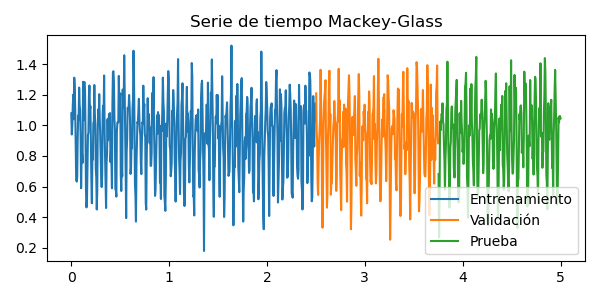

In [2]:
import numpy as np
%matplotlib notebook
import matplotlib.pylab as plt
from mackey import MackeyGlass

# Puede calcular el error medio cuadrático normalizado usando:
NMSE = lambda y, yhat : np.sum((y - yhat)**2)/np.var(y)

# Gráfico
(t_train, y_train), (t_valid, y_valid), (t_test, y_test) = MackeyGlass(tau=17.)
fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)
ax.plot(t_train, y_train, label='Entrenamiento')
ax.plot(t_valid, y_valid, label='Validación')
ax.plot(t_test, y_test, label='Prueba')
ax.set_title('Serie de tiempo Mackey-Glass');
ax.legend();


## (45%) Predicción con algoritmo LMS

1. Describa en detalle el algoritmo LMS e implemente un predictor a un paso basado en el **algoritmo LMS normalizado**
1. Considere el caso $\tau=17$. Entrene su predictor en el conjunto de entrenamiento y encuentre la combinación de parámetros $\mu$ y $L$ que minimiza el NMSE en el conjunto de validación. Se recomienda realizar un barrido logarítmo para $\mu$. Para $L$ pruebe al menos los siguientes valores [5, 10, 20, 30]. Comente sobre lo que observa.
1. Repita el paso anterior para el caso $\tau = 30$
1. Compare los resultados obtenidos con cada serie de tiempo ($\tau=17$ y $\tau=30$). Muestre la predicción en el conjunto de prueba versus su valor real. Muestre también los residuos. Discuta y analice sus resultados

## (45%) Predicción con algoritmo RLS

1. Describa en detalle el algoritmo RLS e implemente un predictor a un paso basado en el algoritmo RLS. Resalte las diferencias con el algoritmo LMS
1. Considere el caso $\tau=17$. Entrene su predictor en el conjunto de entrenamiento y encuentre la combinación de parámetros $\beta$ y $L$ que minimiza el NMSE en el conjunto de validación. Para $L$ pruebe al menos los siguientes valores [5, 10, 20, 30]. Comente sobre lo que observa.
1. Repita el paso anterior para el caso $\tau = 30$
1. Compare los resultados obtenidos con cada serie de tiempo. Muestre la predicción en el conjunto de prueba versus su valor real. Muestre también los residuos. Discuta y analice sus resultados

## (10%) Comparación entre LMS y RLS

1. Compare el mejor predictor LMS y RLS en el conjunto de test en términos de la calidad de la predicción y la velocidad a la que sigue los cambios. Comente y discuta


# Solucion

In [9]:
%matplotlib notebook
import numpy as np
import scipy.signal
import scipy.fft as sfft
import matplotlib.pylab as plt
from matplotlib import animation

from IPython.display import YouTubeVideo, HTML, Audio
from bokeh.layouts import column, row
from bokeh.models import CustomJS, ColumnDataSource, Slider
from bokeh.plotting import Figure, show, output_notebook
output_notebook()

Loading BokehJS ...

## 1.1 Predicción con algoritmo LMS

### Descripcion de algoritmo 

### Implementacion del predictor


In [10]:
class Filtro_NLMS:
    
    def __init__(self, L, mu, delta=1e-6, winit=None):
        self.L = L
        self.w = np.zeros(shape=(L+1, ))
        self.mu = mu
        self.delta = delta
        
    def update(self, un, dn):
        # Asumiendo que un = [u[n], u[n-1], ..., u[n-L]]
        unorm = np.dot(un, un) + self.delta
        yn = np.dot(self.w, un)
        self.w += 2*self.mu*(dn - yn)*(un/unorm)
        return yn

### Entrenamiento del predictor (tau = 17)

In [23]:
(t_train, y_train), (t_valid, y_valid), (t_test, y_test) = MackeyGlass(tau=17.)
t = t_train
u = y_train

In [24]:
from bokeh.palettes import Dark2_5 as palette

L = 30
mus =  np.logspace(-2, 0, num=5)

u_pred = np.zeros(shape=(len(u), len(mus)))
for i, mu in enumerate(mus):
    myfilter = Filtro_NLMS(L=L, mu=mu)
    for k in range(L+1, len(u)):
        u_pred[k, i] = myfilter.update(u[k-L-1:k][::-1], u[k])

p = [Figure(plot_width=720, plot_height=300, toolbar_location="below") for mu in mus]
for i, mu in enumerate(mus):  
    p[i].line(t, u, color='green', line_width=2, legend_label=f"Señal");  
    p[i].line(t, u_pred[:, i], color='blue', line_width=2, legend_label=f"Señal filtrada");
    p[i].title.text = f"Tasa de aprendizaje: {mu:0.4f}"

show(column(p))
    


### Entrenamiento del predictor (tau = 30)

In [17]:
(t_train, y_train), (t_valid, y_valid), (t_test, y_test) = MackeyGlass(tau=30.)
t = t_train
u = y_train

In [18]:
from bokeh.palettes import Dark2_5 as palette

L = 30
mus =  np.logspace(-2, 0, num=5)

u_pred = np.zeros(shape=(len(u), len(mus)))
for i, mu in enumerate(mus):
    myfilter = Filtro_NLMS(L=L, mu=mu)
    for k in range(L+1, len(u)):
        u_pred[k, i] = myfilter.update(u[k-L-1:k][::-1], u[k])

p = [Figure(plot_width=720, plot_height=300, toolbar_location="below") for mu in mus]
for i, mu in enumerate(mus):  
    p[i].line(t, u, color='green', line_width=2, legend_label=f"Señal");  
    p[i].line(t, u_pred[:, i], color='blue', line_width=2, legend_label=f"Señal filtrada");
    p[i].title.text = f"Tasa de aprendizaje: {mu:0.4f}"

show(column(p))

## 1.2 Prediccion con algoritmo RLS

In [52]:
class Filtro_RLS:
    
    def __init__(self, L, beta=0.99, lamb=1e-2):
        self.L = L
        self.w = np.zeros(shape=(L+1, ))
        self.beta = beta
        self.lamb = lamb
        self.Phi_inv = lamb*np.eye(L+1)
        
    def update(self, un, dn):
        # Cálculo de la ganancia
        pi = np.dot(un.T, self.Phi_inv)
        kn = pi.T/(self.beta + np.inner(pi, un))
        # Actualizar el vector de pesos
        error = dn - np.dot(self.w, un)
        self.w += kn*error
        # Actualizar el inverso de Phi
        self.Phi_inv = (self.Phi_inv - np.outer(kn, pi))*self.beta**-1
        return np.dot(self.w, un)


## 1.3 Comparacion entre LMS y RLS